## ⑨
선형적으로 분리되는 데이터셋에 LinearSVC를 훈련시켜보세요. 그런 다음 같은 데이터셋에 SVC와 SGDClassifier를 적용해보세요. 거의 비슷한 모델이 만들어지는지 확인해보세요.

- iris 데이터 불러오기

In [1]:
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

- 필요한 패키지 호출

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

- 기본 설정

In [3]:
# 임계값 설정
c = 5
alpha = 0.05

# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

- 결정 경계 계산 함수 정의

In [21]:
def compute_decision_boundary(model):
    w = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_[0] / model.coef_[0, 1]
    return scaler.inverse_transform([[-10, -10 * w + b], [10, 10 * w + b]])

세 결과가 비슷하기 위해 설정해야할 것
- LinearSVC: `loss = "hinge"`
- SVC: `kernel = "linear"`
- SGD: 규제파라미터 alpha로 설정

1. LinearSVC

In [5]:
linear_svc = LinearSVC(loss = "hinge", C=c, dual = True, random_state = 0).fit(X_scaled, y)

2. SVC

In [6]:
svc = SVC(kernel = "linear", C = c).fit(X_scaled, y)

3. SGDClassifier

In [7]:
sgd = SGDClassifier(alpha = alpha, random_state = 0).fit(X_scaled, y)

- 결정경계 확인

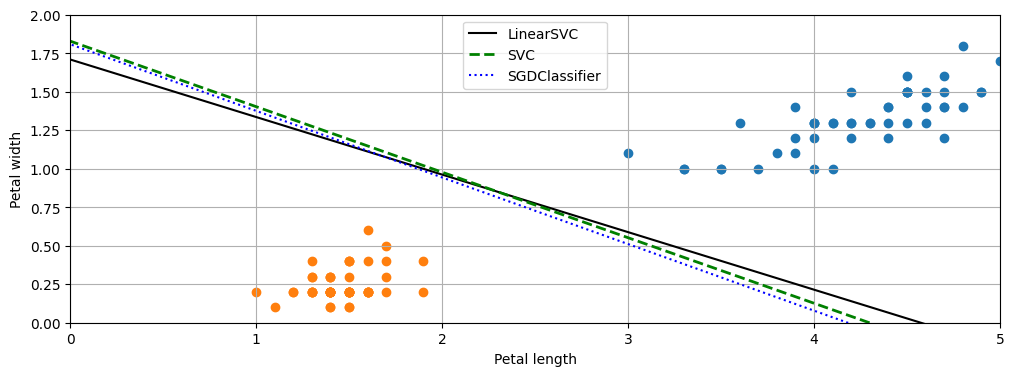

In [28]:
lin_line = compute_decision_boundary(linear_svc)
svc_line = compute_decision_boundary(svc)
sgd_line = compute_decision_boundary(sgd)

# 시각화
plt.figure(figsize=(12, 4))
plt.plot(lin_line[:, 0], lin_line[:, 1], "k-", label="LinearSVC")
plt.plot(svc_line[:, 0], svc_line[:, 1], "g--", linewidth=2, label="SVC")
plt.plot(sgd_line[:, 0], sgd_line[:, 1], "b:", label="SGDClassifier")

plt.scatter(X[:, 0][y==1], X[:, 1][y==1]) # label="Iris versicolor"
plt.scatter(X[:, 0][y==0], X[:, 1][y==0]) # label="Iris setosa"

plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper center")
plt.ylim(0,2)
plt.xlim(0,5)
plt.grid()

plt.show()




## ⑩
sklearn.datasets.load_wine()을 사용해 로드할 수 있는 와인 데이터셋에서 SVM 분류기를 훈련하세요. 이 데이터셋에는 세 명의 재배자가 생성한 와인 샘플 178개의 화학 성분이 포함되어 있습니다. 목표는 와인의 화학 성분을 기반으로 재배자를 예측할 수 있는 분류 모델을 훈련하는 것입니다. SVM 분류기는 이진 분류기이므로 세 가지 클래스를 모두 분류하려면 OvA를 사용해야 합니다. 어느 정도의 정확도에 도달할 수 있나요

- 와인 데이터셋 불러오기

In [29]:
from sklearn.datasets import load_wine

wine = load_wine(as_frame = True)

In [30]:
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

- 필요한 패키지 불러오기

In [39]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from scipy.stats import loguniform, uniform

- 데이터 분리

In [44]:
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, random_state = 30)

In [45]:
X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
42,13.88,1.89,2.59,15.0,101.0,3.25,3.56,0.17,1.70,5.43,0.88,3.56,1095.0
57,13.29,1.97,2.68,16.8,102.0,3.00,3.23,0.31,1.66,6.00,1.07,2.84,1270.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
99,12.29,3.17,2.21,18.0,88.0,2.85,2.99,0.45,2.81,2.30,1.42,2.83,406.0
141,13.36,2.56,2.35,20.0,89.0,1.40,0.50,0.37,0.64,5.60,0.70,2.47,780.0


- 기본 SVM

In [48]:
svm_clf = make_pipeline(StandardScaler(), SVC(random_state=30))
cross_val_score(svm_clf, X_train, y_train).mean()

np.float64(0.9626780626780626)

- LinearSVM: 자동으로 OvR 이용

In [46]:
# 데이터 스케일링 추가
lin_clf = make_pipeline(StandardScaler(),
                        LinearSVC(max_iter = 1000000, dual=True, random_state=30))
lin_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(dual=True, max_iter=1000000, random_state=30))])

In [47]:
cross_val_score(lin_clf, X_train, y_train).mean()

np.float64(0.9851851851851852)

In [55]:
cross_val_score(lin_clf, X_test, y_test).mean()

np.float64(0.9333333333333332)

- 하이퍼 파라미터 튜닝

In [51]:
param_distrib = {
    "svc__gamma": loguniform(0.001, 0.1),
    "svc__C": uniform(1, 10)
}

rnd_cv = RandomizedSearchCV(svm_clf, param_distrib, n_iter=100, cv=5,
                                   random_state=42)
rnd_cv.fit(X_train, y_train)
rnd_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=np.float64(7.842330265121569),
                     gamma=np.float64(0.007591104805282696),
                     random_state=30))])

In [53]:
rnd_cv.best_score_

np.float64(0.9849002849002849)

In [54]:
rnd_cv.score(X_test, y_test)

1.0

-> 과대적합?